In [1]:
import json
import os
import re
import sqlite3
from datetime import datetime
from typing import Annotated, Any, Dict, Literal, TypedDict

import dotenv
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import psycopg2
from langchain.tools import tool
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessagesState, StateGraph, add_messages
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field

dotenv.load_dotenv()
API_KEY = os.getenv("OPENROUTER_API_KEY")
BASE_URL = os.getenv("API_BASE_URL")
# MODEL_NAME = os.getenv("MODEL_NAME")

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "database": "user_db",
    "user": "user",
    "password": "user",
}

## Поднимаем локальную БД

In [2]:
llm = ChatOpenAI(model="qwen/qwen3-coder-30b-a3b-instruct", base_url=BASE_URL, api_key=API_KEY)

## Prompts

In [1]:
ROUTER_PROMPT_TEMPLATE = """
Определи, требует ли задача декомпозиции на подзадачи. Кратко объясни свое решение.

**ЗАДАЧА:** {initial_task}

**DDL схема БД:**
```sql
{ddl_schema}
```

**КРИТЕРИИ:**
- Декомпозиция нужна: если требуется >1 независимых запросов или есть сложные зависимости между запросами
- Декомпозиция НЕ нужна: если один запрос с JOIN/GROUP BY решает задачу

**ПРИМЕРЫ:**
- "Сколько пациентов в районе?" → false (1 запрос)
- "Топ-5 районов по обращениям" → false (1 запрос с GROUP BY)
- "Какие классы болезней в топ-5 районах?" → true (сначала топ-5 районов, потом для каждого анализ)
"""

DDL_SCHEMA = """
-- Таблица пациентов
CREATE TABLE patients (
    "id" INTEGER PRIMARY KEY, -- Идентификатор пациента
    "дата_рождения" DATE, -- Дата рождения пациента
    "пол" VARCHAR(10), -- Пол пациента
    "район_проживания" VARCHAR(100), -- Район проживания пациента
    "регион" VARCHAR(100) -- Регион проживания пациента
);

-- Таблица диагнозов
CREATE TABLE diagnoses (
    "код_мкб" VARCHAR(20) PRIMARY KEY, -- МКБ код диагноза
    "название_диагноза" TEXT, -- Название диагноза
    "класс_заболевания" TEXT -- Классификация диагноза
);

-- Таблица медикаментов
CREATE TABLE medication (
    "код_препарата" INTEGER PRIMARY KEY, -- Код препарата
    "дозировка" VARCHAR(100), -- Дозировка препарата
    "торговое_название" VARCHAR(100), -- Торговое наименование препарата
    "стоимость" FLOAT, -- Цена препарата
    "мета_информация" VARCHAR(200) -- Дополнительная информация о препарате
);

-- Таблица рецептов
CREATE TABLE recipes (
    "дата_рецепта" DATE, -- Дата выписки рецепта
    "код_диагноза" VARCHAR(20), -- МКБ код диагноза
    "код_препарата" INTEGER, -- Код препарата
    "id_пациента" INTEGER, -- Идентификатор пациента
    FOREIGN KEY ("id_пациента") REFERENCES patients("id"),
    FOREIGN KEY ("код_диагноза") REFERENCES diagnoses("код_мкб"),
    FOREIGN KEY ("код_препарата") REFERENCES medication("код_препарата")
);
"""

DECOMPOSITION_PROMPT_TEMPLATE = """
Декомпозируй задачу пользователя на подзадачи. Составь план выполнения. Кратко опиши план.

**ИСХОДНАЯ ЗАДАЧА:** {initial_task}

**DDL схема БД:**
```sql
{ddl_schema}
```

**ОПИСАНИЕ БД:**
База данных содержит информацию о пациентах, их диагнозах, выписанных рецептах и медикаментах, в пределах различных районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Таблицы связаны между собой через внешние ключи, что позволяет эффективно извлекать и анализировать данные.
В БД представлены два региона: 'санкт-Петербург' (СПб) и 'ленинградская область' (ЛО), каждый из которых содержит несколько районов.
Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово']
Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый']

**ПРАВИЛА ДЕКОМПОЗИЦИИ:**
1. Каждая подзадача = один SQL запрос
2. Если результат одной подзадачи нужен для другой - укажи зависимость в depends_on
3. Подзадачи должны быть атомарными и выполняться последовательно

**ПРИМЕРЫ:**

Задача: "Какие классы болезней в топ-3 районах?"
План:
- Подзадача 1: Получить топ-3 районов по количеству рецептов
- Подзадача 2: Для района из топ-1 получить распределение классов болезней (depends_on: [1])
- Подзадача 3: Для района из топ-2 получить распределение классов болезней (depends_on: [1])
- Подзадача 4: Для района из топ-3 получить распределение классов болезней (depends_on: [1])
- Подзадача 5: Агрегировать результаты и найти наиболее частые классы (depends_on: [2, 3, 4])

Задача: "Сравни средний возраст пациентов в Красносельском и Петроградском районах"
План:
- Подзадача 1: Получить средний возраст пациентов в Красносельском районе
- Подзадача 2: Получить средний возраст пациентов в Петроградском районе
- Подзадача 3: Сравнить результаты (depends_on: [1, 2])
"""

SQL_NODE_TEMPLATE = """
Ты генератор SQL запросов, используя СУБД PostgreSQL. Составь SQL запрос для выполнения запроса пользователя.

**НАСТОЯЩЕЕ ВРЕМЯ В ФОРМАТЕ 'DD.MM.YYYY HH:MM:SS':** {current_date}

### **ЗАПРОС ПОЛЬЗОВАТЕЛЯ:**
{user_query}

### **DDL СХЕМА БД:**
```sql
{ddl_schema}
```

### **ОПИСАНИЕ БД:**
База данных содержит информацию о пациентах, их диагнозах, выписанных рецептах и медикаментах, в пределах различных районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Таблицы связаны между собой через внешние ключи, что позволяет эффективно извлекать и анализировать данные.
В БД представлены два региона: 'санкт-Петербург' (СПб) и 'ленинградская область' (ЛО), каждый из которых содержит несколько районов.
Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово']
Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый']

### **ПРАВИЛА ФОРМИРОВАНИЯ SQL ЗАПРОСА:**
1. Не используй кириллицу в SQL запросах для определения переменных!!!
2. Используй только те столбцы и таблицы, которые есть в DDL схеме
3. Если задача сложная, раздели ее на несколько SQL запросов, используя WITH для промежуточных результатов"""

## Simple agent

### Tools

In [ ]:
# @tool
def execute_sql_query(query: str, max_rows: int = 50) -> str:
    """Execute a SQL query and return the results as a JSON string."""
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()

    try:
        cursor.execute(query)
    except Exception as e:
        return f"SQL Error: {str(e)}"

    if query.strip().lower().startswith("select"):
        # Fetch results for SELECT queries
        rows = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        df = pd.DataFrame(rows, columns=columns)

        # Limit the number of returned rows
        df = df.head(max_rows)

        return df.to_json(force_ascii=False, orient="records")

### Workflow

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    sql_query: str
    result: str
    summary: str


class SQLQuery1(BaseModel):
    query: str = Field(description="SQL запрос")

In [ ]:
def sql_generation_node(state: AgentState):
    messages = state["messages"]
    user_query = state.get("user_query", messages[-1].content)
    prompt = SQL_NODE_TEMPLATE.format(
        user_query=user_query,
        ddl_schema=DDL_SCHEMA,
        current_date=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    )
    llm_structured = llm.with_structured_output(SQLQuery1)
    try:
        sql_query = llm_structured.invoke([SystemMessage(content=prompt)])
        return {"sql_query": sql_query.query}
    except Exception as e:
        return f"LLM Error: {str(e)}"


def sql_node(state: AgentState):
    sql_query = state["sql_query"]
    result = execute_sql_query(sql_query)
    return {"result": result}


def summarize_result_node(state: AgentState):
    result = state["result"]
    user_query = state["user_query"]
    prompt = f"""
Резюмируй результаты SQL запроса ```json\n{result}``` для пользователя, опираясь на его изначальный запрос: ```sql\n{user_query}```"""
    summary = llm.invoke([SystemMessage(content=prompt)])
    return {"summary": summary.content}

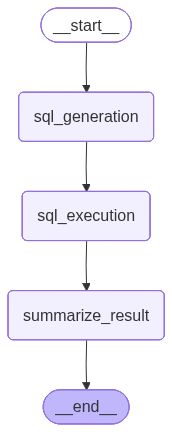

In [223]:
simple_workflow = StateGraph(AgentState)

simple_workflow.add_node("sql_generation", sql_generation_node)
simple_workflow.add_node("sql_execution", sql_node)
simple_workflow.add_node("summarize_result", summarize_result_node)

simple_workflow.set_entry_point("sql_generation")
simple_workflow.add_edge("sql_generation", "sql_execution")
simple_workflow.add_edge("sql_execution", "summarize_result")
simple_workflow.add_edge("summarize_result", END)

app = simple_workflow.compile()
app

In [239]:
user_question = "Какие топ-5 районов по кол-ву обращений?"
initial_state = {"messages": [HumanMessage(content=user_question)], "user_query": user_question}
final_state = app.invoke(initial_state)
print(final_state["sql_query"])
print(final_state["summary"])

WITH обращения_по_районам AS (SELECT p."район_проживания", COUNT(*) AS количество_обращений FROM patients p JOIN recipes r ON p."id" = r."id_пациента" GROUP BY p."район_проживания") SELECT "район_проживания", количество_обращений FROM обращения_по_районам ORDER BY количество_обращений DESC LIMIT 5;
На основе изначального запроса **«Какие топ-5 районов по кол-ву обращений?»**, результаты SQL-запроса должны содержать информацию о **топ-5 районах**, где зарегистрировано **наибольшее количество обращений**.

Предположим, что результаты запроса выглядят следующим образом (в формате JSON, как в вашем примере):

```json
[
  {"district": "Центральный", "count": 1250},
  {"district": "Северный", "count": 980},
  {"district": "Южный", "count": 870},
  {"district": "Восточный", "count": 750},
  {"district": "Западный", "count": 630}
]
```

### Резюме результатов для пользователя:
**Топ-5 районов по количеству обращений:**
1. **Центральный район** — 1250 обращений
2. **Северный район** — 980 обращ

## Agent

In [4]:
class SubTask(BaseModel):
    """Представляет одну подзадачу в плане."""

    description: str = Field(description="Описание подзадачи для выполнения")


class Plan(BaseModel):
    """Представляет многошаговый план для ответа на запрос пользователя."""

    plan: list[SubTask] = Field(description="Список подзадач для выполнения.")


class AgentState(TypedDict):
    """Состояние графа для планирования и выполнения."""

    initial_task: str  # Исходный запрос пользователя
    plan: Plan | None  # План, который может быть создан или None
    current_task_index: int  # Индекс текущей выполняемой задачи
    intermediate_results: list[tuple[str, str]]  # Промежуточные результаты выполнения подзадач
    final_answer: str  # Финальный ответ для пользователя
    plot: str  # Список графиков для визуализации результатов


In [5]:
class ExecuteSQLSchema(BaseModel):
    query: str = Field(description="SQL запрос")


@tool(args_schema=ExecuteSQLSchema)
def execute_sql(query: str, max_rows: int = 25) -> str:
    """Выполняет SQL-запрос и возвращает результат в виде JSON-строки."""

    banned_statements = ["DROP", "DELETE", "UPDATE", "INSERT", "ALTER", "TRUNCATE"]
    if any(statement in query.upper() for statement in banned_statements):
        return "SQL error: Query contains banned statements."

    if not re.search(r"LIMIT\s+\d+\s*;?$", query, re.IGNORECASE):
        if query.strip().endswith(";"):
            query = query.strip()[:-1]
        query += f" LIMIT {max_rows}"

    try:
        with psycopg2.connect(**DB_CONFIG) as conn:
            with conn.cursor() as cursor:
                cursor.execute(query)

                rows = cursor.fetchall()
                columns = [desc[0] for desc in cursor.description]
                df = pd.DataFrame(rows, columns=columns)
                return df.to_json(force_ascii=False, orient="records")
    except Exception as e:
        return f"SQL error: {str(e)}"

In [6]:
@tool
def generate_plot(result_json: str, plot_func: str = "histogram", **kwargs) -> str:
    """
    Универсальный инструмент для построения графиков Plotly Express.
    result_json: JSON-строка с данными (output execute_sql)
    plot_func: имя функции plotly express ('histogram', 'bar', 'scatter', 'pie', 'line', ...)
    **kwargs: любые параметры для функции plotly express (x, y, color, facet_col и т.д.)
    Возвращает: JSON-график Plotly (fig.to_json())
    """
    df = pd.DataFrame(json.loads(result_json))
    px_func = getattr(px, plot_func)
    fig = px_func(df, **kwargs)
    return fig.to_json()

In [24]:
ROUTER_PROMPT_TEMPLATE = """Ты — ИИ-маршрутизатор. Твоя задача — определить, можно ли ответить на запрос пользователя одним SQL-запросом или требуется сложный план из нескольких шагов.
Ответь 'true', если требуется декомпозиция, или 'false' в противном случае. Кратко объясни свое решение.

**ЗАПРОС ПОЛЬЗОВАТЕЛЯ:**
{initial_task}

**СХЕМА БД:**
```sql
{ddl_schema}
```

**КРИТЕРИИ ДЛЯ РЕШЕНИЯ:**
- **'true' (нужен план):**
  - Запрос требует нескольких независимых SQL-запросов (например, сравнение двух разных групп).
  - Результат одного запроса необходим для формулирования следующего (например, найти топ-5 районов, а затем проанализировать каждый из них).
- **'false' (один запрос):**
  - Запрос может быть выполнен одним SQL-запросом, даже если он включает JOIN, GROUP BY или подзапросы.

**ПРИМЕРЫ:**
- "Топ-5 районов по количеству рецептов" → false. Это один запрос с GROUP BY и LIMIT.
- "Сравни средний возраст пациентов в Красносельском и Петроградском районах" → true. Это два отдельных запроса для каждого района, результаты которых затем сравниваются.
- "Какие классы болезней самые частые в топ-3 районах по обращениям?" → true. Сначала нужно найти топ-3 районов, а затем для каждого из них найти классы болезней.
"""

DECOMPOSITION_PROMPT_TEMPLATE = """Ты — ИИ-планировщик. Твоя задача — декомпозировать сложный запрос пользователя на последовательный план выполнения.
Каждый шаг плана должен быть атомарной подзадачей, которую можно выполнить одним SQL-запросом.

**ИСХОДНЫЙ ЗАПРОС:**
{initial_task}

**СХЕМА БД:**
```sql
{ddl_schema}
```

**ОПИСАНИЕ БД:**
База данных содержит информацию о пациентах, их диагнозах, выписанных рецептах и медикаментах, в пределах различных районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Таблицы связаны между собой через внешние ключи, что позволяет эффективно извлекать и анализировать данные.
В БД представлены два региона: 'санкт-петербург' (СПб) и 'ленинградская область' (ЛО), каждый из которых содержит несколько районов.
Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово']
Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый']

**ПРАВИЛА ДЕКОМПОЗИЦИИ:**
1.  Создай логичный, последовательный план.
2.  Каждый шаг должен быть четким и нацеленным на получение конкретной части информации.
3.  Результаты предыдущих шагов могут использоваться в последующих.

**ПРИМЕР:**

**Исходный запрос:** "Сравни средний возраст пациентов в Красносельском и Петроградском районах"
**План:**
- Подзадача 1: Рассчитать средний возраст пациентов в Красносельском районе.
- Подзадача 2: Рассчитать средний возраст пациентов в Петроградском районе.
- Подзадача 3: Сравнить полученные средние возрасты и сформулировать ответ.

**Сгенерируй план для следующего запроса:**
"""

EXECUTION_PROMPT_TEMPLATE = """Ты — ИИ-агент, который должен выполнить одну подзадачу из плана.
У тебя есть доступ к инструменту для выполнения SQL-запросов `execute_sql` и инструменту для построения графиков `generate_plot`.

- Если для выполнения подзадачи нужно получить данные из БД, **вызови инструмент `execute_sql`**.
- Если подзадача не требует обращения к БД (например, это обобщение или сравнение уже полученных результатов), **просто ответь текстом**.

**ОБЩАЯ ЦЕЛЬ (ИСХОДНЫЙ ЗАПРОС):**
{initial_task}

**ТЕКУЩАЯ ПОДЗАДАЧА:**
{sub_task_description}

**КОНТЕКСТ (РЕЗУЛЬТАТЫ ПРЕДЫДУЩИХ ШАГОВ):**
```json
{previous_results}
```

**СХЕМА БД:**
```sql
{ddl_schema}
```
**ОПИСАНИЕ БД:**
База данных содержит информацию о пациентах, их диагнозах, выписанных рецептах и медикаментах, в пределах различных районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Таблицы связаны между собой через внешние ключи, что позволяет эффективно извлекать и анализировать данные.
В БД представлены два региона: 'санкт-петербург' (СПб) и 'ленинградская область' (ЛО), каждый из которых содержит несколько районов.
Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово']
Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый']

**ПРАВИЛА:**
1.  Генерируй только один, полный и готовый к выполнению SQL-запрос.
2.  Используй только таблицы и столбцы из предоставленной схемы.
3.  Не используй кириллицу в названиях полей или псевдонимах в SQL-коде.
4.  Текущая дата: {current_date}. Можешь использовать ее для запросов, связанных с датами.
"""

In [26]:
class RouterDecision(BaseModel):
    """Представляет решение роутера."""

    decision: bool = Field(description="Решение роутера: True или False")


def router_node(state: AgentState) -> Dict[str, Any]:
    """Определяет, нужна ли декомпозиция задачи."""

    router_llm = llm.with_structured_output(RouterDecision, temperature=0)
    prompt = ROUTER_PROMPT_TEMPLATE.format(
        initial_task=state["initial_task"], ddl_schema=DDL_SCHEMA
    )
    decision = router_llm.invoke(prompt).decision

    if decision:
        print("---РЕШЕНИЕ: ТРЕБУЕТСЯ ДЕКОМПОЗИЦИЯ---")
        return {"plan": None}
    else:
        print("---РЕШЕНИЕ: ДЕКОМПОЗИЦИЯ НЕ ТРЕБУЕТСЯ---")
        direct_plan = Plan(plan=[SubTask(description=state["initial_task"])])
        return {"plan": direct_plan}


def planner_node(state: AgentState) -> Dict[str, Any]:
    """Создает план выполнения для сложной задачи."""

    planner_llm = llm.with_structured_output(Plan, temperature=0.3)
    prompt = DECOMPOSITION_PROMPT_TEMPLATE.format(
        initial_task=state["initial_task"], ddl_schema=DDL_SCHEMA
    )
    plan = planner_llm.invoke(prompt)

    print("---СГЕНЕРИРОВАН ПЛАН---")
    for i, task in enumerate(plan.plan):
        print(f"{i + 1}. {task.description}")
    return {"plan": plan}


def execution_node(state: AgentState) -> Dict[str, Any]:
    """Выполняет одну подзадачу из плана, вызывая инструмент или отвечая текстом."""

    plan = state["plan"]
    task_index = state["current_task_index"]
    task = plan.plan[task_index]

    print(f"---ВЫПОЛНЕНИЕ ЗАДАЧИ {task_index + 1}: {task.description}---")

    previous_results = "\n".join(
        f"Результат для '{desc}':\n```json\n{res}```" for desc, res in state["intermediate_results"]
    )

    prompt = EXECUTION_PROMPT_TEMPLATE.format(
        initial_task=state["initial_task"],
        sub_task_description=task.description,
        previous_results=previous_results,
        ddl_schema=DDL_SCHEMA,
        current_date=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    )

    execution_llm = llm.bind_tools([execute_sql])
    response = execution_llm.invoke(prompt)
    result = ""

    if response.tool_calls:
        tool_call = response.tool_calls[0]
        tool_name = tool_call["name"]
        print(f"Tool called: {tool_name}")

        if tool_name == "execute_sql":
            query = tool_call["args"].get("query")
            print(f"SQL: {query}")
            result = execute_sql.invoke(tool_call["args"])
        else:
            result = f"Error: undefined tool called '{tool_name}'."
    else:
        result = response.content
        print(f"Text response: {result}")

    new_results = state["intermediate_results"] + [(task.description, result)]
    return {"intermediate_results": new_results, "current_task_index": task_index + 1}


def summarizer_node(state: AgentState) -> Dict[str, Any]:
    """Формирует финальный ответ на основе всех результатов."""

    prompt = (
        f"Сформируй итоговый ответ на изначальный запрос пользователя, основываясь на результатах выполненных подзадач.\n\n"
        f"**Ответ должен быть кратким, информативным и исчерпывающим**\n\n"
        f"ИСХОДНЫЙ ЗАПРОС: {state['initial_task']}\n\n"
        f"РЕЗУЛЬТАТЫ ПОДЗАДАЧ:\n{state['intermediate_results']}"
    )

    print("---ФОРМИРОВАНИЕ ИТОГОВОГО ОТВЕТА---")
    final_answer = llm.invoke(prompt).content
    return {"final_answer": final_answer}

In [21]:
def route_to_plan_or_execute(state: AgentState) -> Literal["planner", "executor"]:
    """Решает, запускать ли планировщик или сразу переходить к выполнению."""
    return "planner" if state["plan"] is None else "executor"


def should_continue(state: AgentState) -> Literal["executor", "summarizer"]:
    """Проверяет, остались ли еще задачи для выполнения в плане."""
    if state["current_task_index"] < len(state["plan"].plan):
        return "executor"
    return "summarizer"

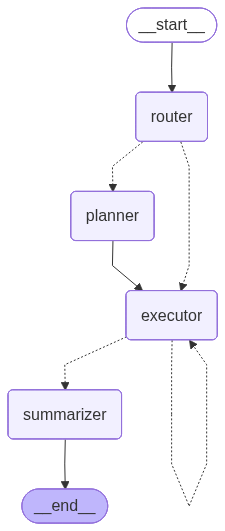

In [22]:
workflow = StateGraph(AgentState)

workflow.add_node("router", router_node)
workflow.add_node("planner", planner_node)
workflow.add_node("executor", execution_node)
workflow.add_node("summarizer", summarizer_node)

workflow.set_entry_point("router")

workflow.add_conditional_edges(
    "router", route_to_plan_or_execute, {"planner": "planner", "executor": "executor"}
)
workflow.add_edge("planner", "executor")

workflow.add_conditional_edges(
    "executor",
    should_continue,
    {"executor": "executor", "summarizer": "summarizer"},  # Цикл для выполнения всех задач
)
workflow.add_edge("summarizer", END)

agent_app = workflow.compile()
agent_app

In [23]:
user_question = "Покажи график распределения пациентов по районам в ЛО"

initial_state = {"initial_task": user_question, "current_task_index": 0, "intermediate_results": []}

final_state = agent_app.invoke(initial_state)

print("\n---ФИНАЛЬНЫЙ ОТВЕТ---")
print(final_state["final_answer"])

---РЕШЕНИЕ: ДЕКОМПОЗИЦИЯ НЕ ТРЕБУЕТСЯ---
---ВЫПОЛНЕНИЕ ЗАДАЧИ 1: Покажи график распределения пациентов по районам в ЛО---
Tool called: execute_sql
SQL: SELECT "район_проживания", COUNT(*) AS patient_count FROM patients WHERE "регион" = 'ленингрдская область' GROUP BY "район_проживания"
---ФОРМИРОВАНИЕ ИТОГОВОГО ОТВЕТА---

---ФИНАЛЬНЫЙ ОТВЕТ---
На основе запроса пользователя и результатов подзадач, графика распределения пациентов по районам Ленинградской области не предоставлено. Для формирования графика необходимы данные о количестве пациентов в каждом районе, которые не были получены или не отображены в результате. Рекомендуется предоставить актуальные данные по районам ЛО для визуализации.
